In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from brokenaxes import brokenaxes
from scipy.optimize import leastsq

from sklearn.utils import assert_all_finite
from sklearn.utils import check_consistent_length
from sklearn.utils import column_or_1d, check_array
from sklearn.utils.multiclass import type_of_target
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.sparsefuncs import count_nonzero
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.preprocessing import label_binarize
from sklearn.metrics.ranking import _binary_clf_curve, roc_curve

import rpy2
from rpy2.robjects.packages import importr
# install bootlr
# import rpy2.robjects.packages as rpackages
# from rpy2.robjects.vectors import StrVector
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1)
# packnames = ('binom', 'bootLR')
# utils.install_packages(StrVector(packnames))

from functools import partial
import multiprocessing
from multiprocessing import Pool

In [2]:
# Flatten _openen files
# n is 5UTR length
# t is downstream distance to start codon to include
def openen_label(n, t, f):
    d = pd.read_csv(f, sep='\t', skiprows=2, nrows=(n+t), header=None)
    d = d.set_index(0).stack().to_frame()
    d = d.index.to_frame()
    d.columns = ["Position 'i' centered at the start codon", "Subsegment 'l'"]
    d = d.reset_index()[["Position 'i' centered at the start codon", "Subsegment 'l'"]]
    d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"] - n
    return d

# Get opening energy at a specific subsegment 'l'
# and position 'i' centered at the start codon
def get_openen(n, t, f1, l, i, f2):
    label = openen_label(n, t, f1)
    d = pd.read_pickle(f2)
    d = d.set_index('id')
    d = d.T
    d = pd.concat([label, d], axis=1)
    o = d.loc[(d["Subsegment 'l'"] == l) & (d["Position 'i' centered at the start codon"] == i)]
    o = o.T[2:]
    o.columns = ['Opening energy']
    return o

def roc(outcomes, prediction):
    fps, tps, thresholds = _binary_clf_curve(outcomes, prediction)
    clf = pd.DataFrame([fps, tps, thresholds]).T
    clf.columns = ['fps', 'tps', 'thresholds']
    clf['fps'] = clf['fps'].astype(int)
    clf['tps'] = clf['tps'].astype(int)
    fpr, tpr, thresholds = roc_curve(outcomes, prediction, drop_intermediate=False)
    r = pd.DataFrame([fpr, tpr, thresholds]).T
    r.columns = ['fpr', 'tpr', 'thresholds']
    df = pd.merge(clf, r, on='thresholds')
    return df

def run_bootlr(P, N, d):
    r = rpy2.robjects.r
    set_seed = r('set.seed')
    set_seed(12345)
    bootLR = importr('bootLR')
    truePos=int(d[1])
    trueNeg=N-int(d[0])
    lr = bootLR.BayesianLR_test(truePos=truePos, totalDzPos=P, trueNeg=trueNeg, totalDzNeg=N)
    lr = [lr.rx('posLR')[0][0], lr.rx('posLR.ci')[0][0], lr.rx('posLR.ci')[0][1],
         lr.rx('negLR')[0][0], lr.rx('negLR.ci')[0][0], lr.rx('negLR.ci')[0][1]]
    x = d
    x.extend(lr)
    print(x)

# shamelessly taken from https://people.duke.edu/~ccc14/pcfb/analysis.html
def logistic4(x, A, B, C, D):
    """4PL lgoistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C,D = p
    return logistic4(x, A, B, C, D)

In [3]:
d = get_openen(71, 100, 'data/AaCD00331182_openen', 48, 24, 'data/openen.pET21_NESG.pkl')
d = d.reset_index()
d.columns = ['Accession', 'Opening energy']
c = pd.read_csv('data/class.txt', sep='\t')
c = c.replace(2,1)
d = pd.merge(d, c, on='Accession')
d = roc(d['Class'], -d['Opening energy'])
d = d.values.tolist() #fps tps thresholds fpr tpr

In [ ]:
# not run
print(['fps', 'tps', 'thresholds', 'fpr', 'tpr', 'posLR', 'posLR.ci.lower', 'posLR.ci.upper', 'negLR negLR.ci.lower', 'negLR.ci.upper'])
p = Pool(16)
bootlr = partial(run_bootlr, 8780, 2650)
p.imap_unordered(bootlr, d)
p.close()
p.join()

```console
python bootlr.py 2>&1 | bootlr.log
# remove warning messages regarding invalid confidene intervals.
# This happens when sensitivity is 1 and specificity is zero, and vice versa
cat \
<(grep posLR bootlr.log | sed 's/,//g;s/ /\t/g') \
<(grep -v posLR bootlr.log | sed 's/,//g;s/ /\t/g;s/\[//;s/\]//;/^$/d;s/-//g' | sort -k3,3n | awk '!/[a-z]/ && NF>0 {sub("\\[","\n");sub("\\]",""); print}' | sort -k8,8nr) \
> bootlr.txt
```

In [4]:
# read in bootstrap results
d = pd.read_csv('data/bootlr.txt', sep='\t')

In [5]:
# rows containing Inf were removed due bootLR error messages
#Error in run.BayesianLR.test(truePos = truePos, totalDzPos = totalDzPos, : In some of your draws, sensitivity was 1 at the same time that specificity was 0. 
#This most likely resulted because you had a sensitivity of 1 and a specificity of close to 0, or vice-versa. 
#The algorithm is not designed to handle this case, and may not ever be. 
#Please do not just re-run the algorithm until you no longer receive this message, as the confidence intervals so obtained will be invalid.
d.sort_values('posLR.ci.upper', ascending=False).head(n=10)

,fps,tps,thresholds,fpr,tpr,posLR,posLR.ci.lower,posLR.ci.upper,negLR,negLR.ci.lower,negLR.ci.upper
0,4.0,46.0,4.3981,0.001509,0.005239,3.470957,1.489764,16.098138,0.996265,0.994209,0.998452
1,4.0,43.0,4.3549,0.001509,0.004897,3.244590,1.383560,14.879459,0.996607,0.994599,0.998772
2,4.0,44.0,4.3619,0.001509,0.005011,3.320046,1.395184,14.810967,0.996493,0.994462,0.998658
3,4.0,41.0,4.3492,0.001509,0.004670,3.093679,1.313794,14.250706,0.996835,0.994854,0.998981
4,4.0,39.0,4.3336,0.001509,0.004442,2.942768,1.245272,13.618436,0.997063,0.995110,0.999187
5,4.0,37.0,4.3286,0.001509,0.004214,2.791856,1.149899,12.453189,0.997291,0.995366,0.999400
6,4.0,34.0,4.2615,0.001509,0.003872,2.565490,1.047595,11.571868,0.997633,0.995761,0.999720
7,11.0,101.0,4.7429,0.004151,0.011503,2.771278,1.586098,5.917397,0.992617,0.989402,0.996053
8,11.0,100.0,4.7424,0.004151,0.011390,2.743839,1.569390,5.857779,0.992731,0.989526,0.996161
9,10.0,85.0,4.6590,0.003774,0.009681,2.565490,1.430836,5.796067,0.994070,0.991067,0.997309


In [6]:
# Least-squares 4 parameter logistic regression fit to positive likelihood ratio
p0 = [1, 1, 1, 0]
plsq = leastsq(residuals, p0, args=(d['posLR'], d['thresholds']))
d['posLR_4PL'] = peval(d['thresholds'],plsq[0])
d['tns'] = 2650-d['fps']
d['fns'] = 8780-d['tps']
d = d.sort_values('thresholds')

In [7]:
d.head()

,fps,tps,thresholds,fpr,tpr,posLR,posLR.ci.lower,posLR.ci.upper,negLR,negLR.ci.lower,negLR.ci.upper,posLR_4PL,tns,fns
6,4.0,34.0,4.2615,0.001509,0.003872,2.565490,1.047595,11.571868,0.997633,0.995761,0.999720,2.383108,2646.0,8746.0
5,4.0,37.0,4.3286,0.001509,0.004214,2.791856,1.149899,12.453189,0.997291,0.995366,0.999400,2.382916,2646.0,8743.0
4,4.0,39.0,4.3336,0.001509,0.004442,2.942768,1.245272,13.618436,0.997063,0.995110,0.999187,2.382901,2646.0,8741.0
3,4.0,41.0,4.3492,0.001509,0.004670,3.093679,1.313794,14.250706,0.996835,0.994854,0.998981,2.382854,2646.0,8739.0
1,4.0,43.0,4.3549,0.001509,0.004897,3.244590,1.383560,14.879459,0.996607,0.994599,0.998772,2.382837,2646.0,8737.0


In [8]:
# calculate R-squared
p = plsq[0]
res = residuals(p, d['posLR'], d['thresholds'])
ss_res = np.sum(res**2)
ss_tot = np.sum((d['posLR']-np.mean(d['posLR']))**2)
r_squared = 1 - (ss_res / ss_tot)

In [9]:
r_squared

0.9452714822630413

The distribution residuals is not perfectly symmetrical but R squared > 0.9

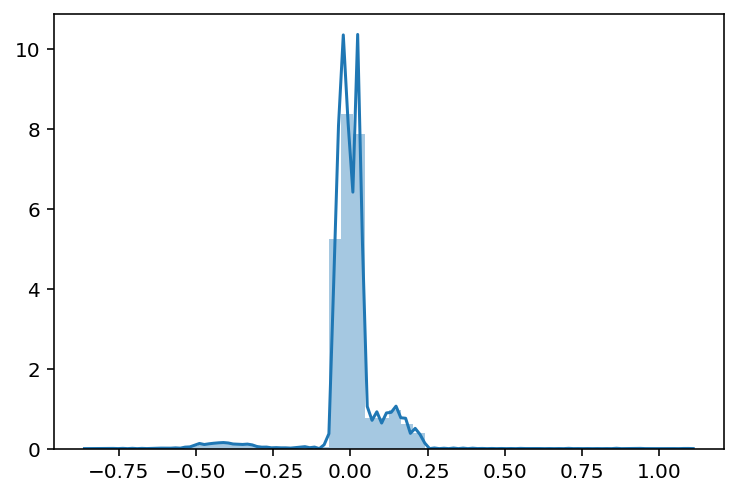

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.distplot(res)

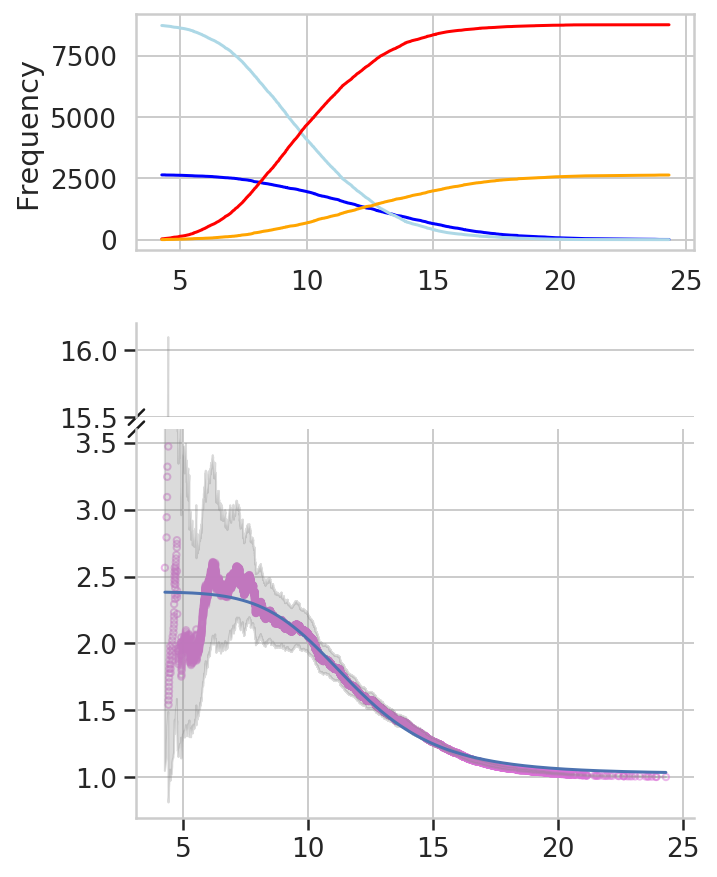

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sps1, sps2 = GridSpec(2,1)
fig = plt.figure(figsize=(5,10))
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

bax = brokenaxes(subplot_spec=sps1)
bax = plt.subplot2grid((4,1), (1,0)) 
bax.plot('thresholds', 'tns', data=d, color='blue', label='True Negative')
bax.plot('thresholds', 'fns', data=d, color='lightblue', label='False Negative')
bax.plot('thresholds', 'tps', data=d, color='red', label='True positive')
bax.plot('thresholds', 'fps', data=d, color='orange', label='False positive')
bax.set_ylabel('Frequency')
# bax.legend(loc=1)

bax = brokenaxes(ylims=((0.7, 3.6), (15.5, 16.2)), hspace=.05, subplot_spec=sps2)
bax.plot('thresholds', 'posLR_4PL', data=d, label='4 parameter logistic curve')
bax.scatter('thresholds', 'posLR', alpha=0.5, color='orchid', data=d, s=10, facecolors='none', label='Positive likelihood ratio')
bax.fill_between('thresholds', 'posLR.ci.lower', 'posLR.ci.upper', color='#888888', alpha=0.3, data=d, label='Confidence intervals')
# bax.set_xlabel('Opening energy')
# bax.set_ylabel('Positive likelihood ratio')
# bax.legend(loc=1)
# plt.savefig('data/fig5.png', dpi=600)

In [12]:
# export table for calculation of posterior probability and score
d.to_csv('data/4pl.csv', index=None)